In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator

# Create example data points and values
np.random.seed(0)
n_points = 100000
n_interp_points = 1000

# Randomly generate points in 3D space
points = np.random.rand(n_points, 3)
values = np.random.rand(n_points)

# Generate random query points
query_points = np.random.rand(n_interp_points, 3)

# Create the LinearNDInterpolator using all the points and values
interpolator = LinearNDInterpolator(points, values)

# Perform the interpolation on the query points
interpolated_values = interpolator(query_points)

# Print some of the interpolated results
print(interpolated_values[:10])

In [ ]:
import numpy as np
import dask.array as da
from scipy.interpolate import LinearNDInterpolator
from dask import delayed
from dask.distributed import Client

# Start a Dask client for parallel computation
client = Client()

# Create example data points and values
np.random.seed(0)
n_points = 100000
n_interp_points = 1000

# Randomly generate points in 3D space
points = np.random.rand(n_points, 3)
values = np.random.rand(n_points)

# Wrap points and values in dask arrays for parallel processing
dask_points = da.from_array(points, chunks=(n_points // 10, 3))
dask_values = da.from_array(values, chunks=(n_points // 10,))

# Generate random query points
query_points = np.random.rand(n_interp_points, 3)

# Define a function for interpolation that handles chunks correctly
def interpolate_chunk(points_chunk, values_chunk, query_points):
    # Perform interpolation using the actual data (NumPy arrays)
    interpolator = LinearNDInterpolator(points_chunk, values_chunk)
    return interpolator(query_points)

# Apply the interpolation function to each chunk using dask.delayed
results = []
for points_chunk, values_chunk in zip(dask_points.to_delayed(), dask_values.to_delayed()):
    # Compute the chunk and then apply interpolation
    result = delayed(interpolate_chunk)(delayed(np.array)(points_chunk), delayed(np.array)(values_chunk), query_points)
    results.append(result)

# Compute all results
interpolated_values = delayed(np.stack)(results)

# Compute the final result
final_result = interpolated_values.compute()

# Print some of the interpolated results
print(final_result[:10])

# Close the client
client.close()

In [ ]:
import numpy as np
import dask.array as da
from scipy.interpolate import LinearNDInterpolator
from dask import delayed
from dask.distributed import Client

# Start a Dask client for parallel computation
client = Client()

# Create example data points and values
np.random.seed(0)
n_points = 100000
n_interp_points = 1000

# Randomly generate points in 3D space
points = np.random.rand(n_points, 3)
values = np.random.rand(n_points)

# Adjust the chunking to properly chunk along the first axis (i.e., split points into chunks)
chunk_size = n_points // 10
dask_points = da.from_array(points, chunks=(chunk_size, 3))
dask_values = da.from_array(values, chunks=(chunk_size,))

# Generate random query points
query_points = np.random.rand(n_interp_points, 3)

# Define a function for interpolation that handles chunks correctly
def interpolate_chunk(points_chunk, values_chunk, query_points):
    # Ensure the chunk has the right shape
    points_chunk = np.array(points_chunk)
    values_chunk = np.array(values_chunk)

    # Verify the shape of the points_chunk and values_chunk
    if points_chunk.ndim != 2 or points_chunk.shape[1] != 3:
        raise ValueError(f"points_chunk has incorrect shape {points_chunk.shape}, expected (n_points_in_chunk, 3)")
    if values_chunk.ndim != 1 or values_chunk.shape[0] != points_chunk.shape[0]:
        raise ValueError(f"values_chunk has incorrect shape {values_chunk.shape}, expected (n_points_in_chunk,)")

    # Perform interpolation using the actual data (NumPy arrays)
    interpolator = LinearNDInterpolator(points_chunk, values_chunk)
    return interpolator(query_points)

# Apply the interpolation function to each chunk using dask.delayed
results = []
for points_chunk, values_chunk in zip(dask_points.to_delayed(), dask_values.to_delayed()):
    # Delay the computation of each interpolation task
    result = delayed(interpolate_chunk)(points_chunk, values_chunk, query_points)
    results.append(result)

# Compute all results in parallel
computed_results = delayed(np.stack)(results)

# Compute the final result
final_result = computed_results.compute()

# Print some of the interpolated results
print(final_result[:10])

# Close the client
client.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
import time

# Measure total execution time
start_time = time.time()

# Generate random numbers using numpy
start_generation_time = time.time()

N = 5000000

rng = np.random.default_rng()
x = rng.random(N) - 0.5
y = rng.random(N) - 0.5
z = np.hypot(x, y)

generation_time = time.time() - start_generation_time

# Create X and Y grids
start_grid_time = time.time()

X = np.linspace(min(x), max(x), 1000)
Y = np.linspace(min(y), max(y), 1000)
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

grid_time = time.time() - start_grid_time

# Interpolation process
start_interpolation_time = time.time()

interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)

interpolation_time = time.time() - start_interpolation_time

# Plotting
start_plot_time = time.time()

plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

plot_time = time.time() - start_plot_time

# Total time
total_time = time.time() - start_time

# Print timing information
print(f"Time to generate random data: {generation_time:.4f} seconds")
print(f"Time to create grid: {grid_time:.4f} seconds")
print(f"Time for interpolation: {interpolation_time:.4f} seconds")
print(f"Time for plotting: {plot_time:.4f} seconds")
print(f"Total time: {total_time:.4f} seconds")

In [ ]:
import numpy as np
import dask.array as da
from scipy.interpolate import LinearNDInterpolator
import dask
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import time

N = 5000000

# Generate random numbers using numpy
rng = np.random.default_rng()

x = rng.random(N) - 0.5
y = rng.random(N) - 0.5
z = np.hypot(x, y)

# Create X and Y grids using dask arrays
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

X = da.linspace(x_min, x_max, 1000)
Y = da.linspace(y_min, y_max, 1000)
X, Y = da.meshgrid(X, Y)  # 2D grid for interpolation

# Use delayed to parallelize the interpolation process
@dask.delayed
def interpolate_and_meshgrid(x, y, z, X, Y):
    interp = LinearNDInterpolator(list(zip(x, y)), z)
    Z = interp(X, Y)
    return Z

# Measure the time of the delayed task creation
start_time = time.time()

# Call the delayed function for interpolation
Z_delayed = interpolate_and_meshgrid(x, y, z, X.compute(), Y.compute())

# Measure the time it takes to create the delayed task (not yet executed)
task_creation_time = time.time() - start_time

# Trigger the computation
start_computation_time = time.time()

with ProgressBar():
    Z = Z_delayed.compute()

computation_time = time.time() - start_computation_time

# Total time
total_time = time.time() - start_time

# Print timing information
print(f"Time to create delayed task: {task_creation_time:.4f} seconds")
print(f"Time to compute task: {computation_time:.4f} seconds")
print(f"Total time: {total_time:.4f} seconds")

# Plotting
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [ ]:
import numpy as np
import dask.array as da
from scipy.interpolate import LinearNDInterpolator
import dask
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import time

# Connect to an existing client and close it if one exists
client = Client()
client.shutdown()  # Gracefully shut down the existing cluster

# Now, create a new cluster
# Setup Dask cluster with a specified number of threads or processes
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)

# Measure total execution time
start_time = time.time()

# Generate random numbers using numpy
start_generation_time = time.time()

N = 50000000

rng = np.random.default_rng()
x = rng.random(N) - 0.5
y = rng.random(N) - 0.5
z = np.hypot(x, y)

print(x.shape)

generation_time = time.time() - start_generation_time

# Create X and Y grids using dask arrays
start_grid_time = time.time()

x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

X = da.linspace(x_min, x_max, 1000)
Y = da.linspace(y_min, y_max, 1000)
X, Y = da.meshgrid(X, Y)  # 2D grid for interpolation

print(X.shape)

grid_time = time.time() - start_grid_time

# Use delayed to parallelize the interpolation process
@dask.delayed
def interpolate_and_meshgrid(x, y, z, X, Y):
    interp = LinearNDInterpolator(list(zip(x, y)), z)
    Z = interp(X, Y)
    return Z

# Measure the time of the delayed task creation
start_task_creation_time = time.time()

# Call the delayed function for interpolation
Z_delayed = interpolate_and_meshgrid(x, y, z, X.compute(), Y.compute())

task_creation_time = time.time() - start_task_creation_time

# Trigger the computation
start_computation_time = time.time()

with ProgressBar():
    Z = Z_delayed.compute()

computation_time = time.time() - start_computation_time

# Total time
total_time = time.time() - start_time

# Print timing information
print(f"Time to generate random data: {generation_time:.4f} seconds")
print(f"Time to create grid: {grid_time:.4f} seconds")
print(f"Time to create delayed task: {task_creation_time:.4f} seconds")
print(f"Time to compute task: {computation_time:.4f} seconds")
print(f"Total time: {total_time:.4f} seconds")

# Plotting
#start_plot_time = time.time()

#plt.pcolormesh(X, Y, Z, shading='auto')
#plt.plot(x, y, "ok", label="input point")
#plt.legend()
#plt.colorbar()
#plt.axis("equal")
#plt.show()

#plot_time = time.time() - start_plot_time

# Print plotting time
#print(f"Time for plotting: {plot_time:.4f} seconds")
#client.close() 

In [ ]:
from dask.distributed import Client, LocalCluster
# Connect to an existing client and close it if one exists
client = Client()
client.shutdown()  # Gracefully shut down the existing cluster

In [ ]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

np.random.seed(4)

N1 = 1000
N2 = 100

# Assume these are your non-rectilinear grid points and temperature values
# x and y are 10,000 by 10,000 arrays representing the grid coordinates
# temperature is a 10,000 by 10,000 array representing temperature values at each grid point
x = np.random.rand(N1, N1)
y = np.random.rand(N1, N1)
temperature = np.random.rand(N1, N1)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Construct the KDTree from the points
tree = KDTree(points)

# Create a rectilinear grid where you want to interpolate the data (1000x1000 grid)
x_lin = np.linspace(x.min(), x.max(), N2)
y_lin = np.linspace(y.min(), y.max(), N2)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Flatten the rectilinear grid to get a list of query points
query_points = np.vstack([x_rect.ravel(), y_rect.ravel()]).T

# Query the KDTree to find the nearest neighbors in the original data
distances, indices = tree.query(query_points)

# Plot the original data (since the data is too large, we plot a smaller subset)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot a subset of the original temperature data
subset_size = 1000  # Plot a subset to make it manageable
subset_indices = np.random.choice(x.size, subset_size, replace=False)

sc = axs[0].scatter(x.ravel()[subset_indices], y.ravel()[subset_indices], c=temperature.ravel()[subset_indices], s=1, cmap='viridis')
axs[0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0], label='Temperature')

# Plot the interpolated data
im = axs[1].imshow(interpolated_temperature, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='viridis')
axs[1].set_title('Interpolated Temperature on Rectilinear Grid')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im, ax=axs[1], label='Temperature')

plt.show() 


In [ ]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

N = 1000
M = 100

# Assume these are your non-rectilinear grid points and temperature values
# x and y are 10,000 by 10,000 arrays representing the grid coordinates
# temperature is a 10,000 by 10,000 array representing temperature values at each grid point
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Construct the KDTree from the points
tree = KDTree(points)

# Create a rectilinear grid where you want to interpolate the data (1000x1000 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Flatten the rectilinear grid to get a list of query points
query_points = np.vstack([x_rect.ravel(), y_rect.ravel()]).T

# Query the KDTree to find the nearest neighbors in the original data
distances, indices = tree.query(query_points)

# Use the indices to get the interpolated temperature values
interpolated_temperature = values[indices].reshape(M, M)

# Plot the original data (since the data is too large, we plot a smaller subset)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot a subset of the original temperature data
#subset_size = 1000  # Plot a subset to make it manageable
#subset_indices = np.random.choice(x.size, subset_size, replace=False)

#sc = axs[0].scatter(x.ravel()[subset_indices], y.ravel()[subset_indices], c=temperature.ravel()[subset_indices], s=1, cmap='viridis')
sc = axs[0].scatter(x.ravel()[:], y.ravel()[:], c=temperature.ravel()[:], s=1, cmap='viridis')
axs[0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0], label='Temperature')

# Plot the interpolated data
im = axs[1].imshow(interpolated_temperature, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='viridis')
axs[1].set_title('Interpolated Temperature on Rectilinear Grid')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im, ax=axs[1], label='Temperature')

plt.show()

In [ ]:
import numpy as np
from scipy.spatial import KDTree
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import time

N = 1000
M = 100

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (1000x1000 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Flatten the rectilinear grid to get a list of query points
query_points = np.vstack([x_rect.ravel(), y_rect.ravel()]).T

# KDTree method
start_time = time.time()
tree = KDTree(points)
distances, indices = tree.query(query_points)
interpolated_temperature_kdtree = values[indices].reshape(M, M)
kdtree_time = time.time() - start_time

# LinearNDInterpolator method
start_time = time.time()
interpolator = LinearNDInterpolator(points, values)
interpolated_temperature_linear = interpolator(x_rect, y_rect)
linear_time = time.time() - start_time

# Compare the two methods
mae = np.mean(np.abs(interpolated_temperature_kdtree - interpolated_temperature_linear))

# Print the timing results and mean absolute error
print(f"KDTree interpolation time: {kdtree_time:.4f} seconds")
print(f"LinearNDInterpolator interpolation time: {linear_time:.4f} seconds")
print(f"Mean Absolute Error between KDTree and LinearNDInterpolator: {mae:.4e}")

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# KDTree Interpolated Data
im1 = axs[0].imshow(interpolated_temperature_kdtree, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='viridis')
axs[0].set_title('Interpolated Temperature using KDTree')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0], label='Temperature')

# LinearNDInterpolator Interpolated Data
im2 = axs[1].imshow(interpolated_temperature_linear, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='viridis')
axs[1].set_title('Interpolated Temperature using LinearNDInterpolator')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1], label='Temperature')

# Difference between the two methods
difference = interpolated_temperature_kdtree - interpolated_temperature_linear
im3 = axs[2].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[2].set_title('Difference between KDTree and LinearNDInterpolator')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
fig.colorbar(im3, ax=axs[2], label='Temperature Difference')

plt.show()

In [ ]:
import numpy as np
from scipy.spatial import KDTree
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import dask.array as da

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(10000, 10000)
y = np.random.rand(10000, 10000)
temperature = np.random.rand(10000, 10000)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T

# Construct the KDTree from the points
tree = KDTree(points)

# Create a rectilinear grid where you want to interpolate the data (1000x1000 grid)
x_lin = np.linspace(x.min(), x.max(), 1000)
y_lin = np.linspace(y.min(), y.max(), 1000)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Flatten the rectilinear grid to get a list of query points
query_points = np.vstack([x_rect.ravel(), y_rect.ravel()]).T

# Convert the query points to a dask array with chunks
chunk_size = 100000  # Define a reasonable chunk size based on memory capacity
query_points_dask = da.from_array(query_points, chunks=(chunk_size, 2))

# Initialize an empty list to store the interpolated chunks
interpolated_chunks = []

# Loop through each chunk and perform KDTree interpolation
for i in range(query_points_dask.numblocks[0]):
    # Extract the chunk
    query_chunk = query_points_dask.blocks[i].compute()
    
    # Perform KDTree query on the chunk
    _, indices = tree.query(query_chunk)
    
    # Extract the interpolated temperature values for this chunk
    interpolated_chunk = temperature.ravel()[indices]
    
    # Append the interpolated chunk to the list
    interpolated_chunks.append(interpolated_chunk)

# Combine the chunks into the final interpolated array
interpolated_temperature_kdtree = np.concatenate(interpolated_chunks)

# Reshape the resulting array back to the 1000x1000 grid shape
interpolated_temperature_kdtree = interpolated_temperature_kdtree.reshape(1000, 1000)

# Perform interpolation using LinearNDInterpolator for comparison
interpolator = LinearNDInterpolator(points, temperature.ravel())
interpolated_temperature_linear = interpolator(x_rect, y_rect)

# Compare the two methods
mae = np.mean(np.abs(interpolated_temperature_kdtree - interpolated_temperature_linear))

# Print the mean absolute error
print(f"Mean Absolute Error between KDTree and LinearNDInterpolator: {mae:.4e}")

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# KDTree Interpolated Data
im1 = axs[0].imshow(interpolated_temperature_kdtree, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='viridis')
axs[0].set_title('Interpolated Temperature using KDTree (Chunked)')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0], label='Temperature')

# LinearNDInterpolator Interpolated Data
im2 = axs[1].imshow(interpolated_temperature_linear, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='viridis')
axs[1].set_title('Interpolated Temperature using LinearNDInterpolator')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1], label='Temperature')

# Difference between the two methods
difference = interpolated_temperature_kdtree - interpolated_temperature_linear
im3 = axs[2].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[2].set_title('Difference between KDTree and LinearNDInterpolator')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
fig.colorbar(im3, ax=axs[2], label='Temperature Difference')

plt.show()

In [ ]:
import numpy as np
from scipy.spatial import KDTree
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import time

N = 1000
M = 100

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

def inter_temp(points, values, x_rect, y_rect):

    #interpolator = LinearNDInterpolator(points, values)
    #interpolated_temperature_linear = interpolator(x_rect, y_rect)
    
    return interpolated_temperature_linear

# LinearNDInterpolator method
start_time = time.time()

#for i in range(): 

#interpolator = LinearNDInterpolator(points, values)
#interpolated_temperature_linear = interpolator(x_rect, y_rect)
linear_time = time.time() - start_time

print(f"LinearNDInterpolator interpolation time: {linear_time:.4f} seconds")

In [ ]:
import numpy as np
from scipy.spatial import KDTree
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import time

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
chunk_size = 100000  # Define the chunk size

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize an array to store the interpolated values on the coarse grid
coarse_temperature = np.zeros((M, M))

# Process the data in chunks
num_points = points.shape[0]
for i in range(0, num_points, chunk_size):
    # Select the chunk
    chunk_points = points[i:i+chunk_size]
    chunk_values = values[i:i+chunk_size]
    
    # Interpolate using LinearNDInterpolator
    interpolator = LinearNDInterpolator(chunk_points, chunk_values)
    
    # Perform interpolation on the coarse grid
    coarse_temperature_chunk = interpolator(x_rect, y_rect)
    
    # Accumulate the results
    coarse_temperature += np.nan_to_num(coarse_temperature_chunk)

# Since each chunk contributed to the sum, we divide by the number of contributions
# However, since there can be overlapping chunks with different points, we should keep track of how many chunks contribute to each point
contribution_count = np.zeros((M, M))
for i in range(0, num_points, chunk_size):
    chunk_points = points[i:i+chunk_size]
    
    # Interpolate using LinearNDInterpolator
    interpolator = LinearNDInterpolator(chunk_points, np.ones_like(chunk_points[:, 0]))
    
    # Increment the contribution count
    contribution_chunk = interpolator(x_rect, y_rect)
    contribution_count += np.nan_to_num(contribution_chunk)

# Normalize by the number of contributions
coarse_temperature /= np.maximum(contribution_count, 1)

# Plot the interpolated coarse grid temperature
plt.figure(figsize=(8, 6))
plt.contourf(x_rect, y_rect, coarse_temperature, levels=100, cmap='coolwarm')
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated Temperature on Coarse Grid')
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

np.random.seed(6)

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
chunk_size = 100000  # Define the chunk size

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize an array to store the interpolated values on the coarse grid
coarse_temperature = np.zeros((M, M))

# Process the data in chunks
num_points = points.shape[0]
for i in range(0, num_points, chunk_size):
    # Select the chunk
    chunk_points = points[i:i+chunk_size]
    chunk_values = values[i:i+chunk_size]
    
    # Interpolate using LinearNDInterpolator
    interpolator = LinearNDInterpolator(chunk_points, chunk_values)
    
    # Perform interpolation on the coarse grid
    coarse_temperature_chunk = interpolator(x_rect, y_rect)
    
    # Accumulate the results
    coarse_temperature += np.nan_to_num(coarse_temperature_chunk)

# Since each chunk contributed to the sum, we divide by the number of contributions
# However, since there can be overlapping chunks with different points, we should keep track of how many chunks contribute to each point
contribution_count = np.zeros((M, M))
for i in range(0, num_points, chunk_size):
    chunk_points = points[i:i+chunk_size]
    
    # Interpolate using LinearNDInterpolator
    interpolator = LinearNDInterpolator(chunk_points, np.ones_like(chunk_points[:, 0]))
    
    # Increment the contribution count
    contribution_chunk = interpolator(x_rect, y_rect)
    contribution_count += np.nan_to_num(contribution_chunk)

# Normalize by the number of contributions
coarse_temperature /= np.maximum(contribution_count, 1)

# Plot the original data (since the data is too large, we plot a smaller subset)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot a subset of the original temperature data
#subset_size = 1000  # Plot a subset to make it manageable
#subset_indices = np.random.choice(x.size, subset_size, replace=False)

x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

#sc = axs[0].scatter(x.ravel()[subset_indices], y.ravel()[subset_indices], c=temperature.ravel()[subset_indices], s=1, cmap='viridis')
sc = axs[0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0], label='Temperature')

# Plot the interpolated data
im = axs[1].imshow(coarse_temperature, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1].set_title('Interpolated Temperature on Rectilinear Grid')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im, ax=axs[1], label='Temperature')

plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

np.random.seed(6)

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
chunk_size = 100000  # Define the chunk size

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize an array to store the interpolated values on the coarse grid
coarse_temperature = np.zeros((M, M))

# Since each chunk contributed to the sum, we divide by the number of contributions
# However, since there can be overlapping chunks with different points, we should keep track of how many chunks contribute to each point
# Initialize arrays to store the interpolated values and contribution count on the coarse grid
coarse_temperature = np.zeros((M, M))
contribution_count = np.zeros((M, M))

# Process the data in chunks
num_points = points.shape[0]
for i in range(0, num_points, chunk_size):
    # Select the chunk
    chunk_points = points[i:i+chunk_size]
    chunk_values = values[i:i+chunk_size]
    
    # Interpolate using LinearNDInterpolator
    interpolator = LinearNDInterpolator(chunk_points, chunk_values)
    coarse_temperature_chunk = interpolator(x_rect, y_rect)
    
    # Add the chunk's interpolated results to the cumulative coarse_temperature
    coarse_temperature += np.nan_to_num(coarse_temperature_chunk)
    
    # Increment the contribution count where the interpolation was valid
    contribution_chunk = np.isfinite(coarse_temperature_chunk).astype(int)
    contribution_count += contribution_chunk

# Normalize by the number of contributions
coarse_temperature /= np.maximum(contribution_count, 1)

# Plot the original data (since the data is too large, we plot a smaller subset)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot a subset of the original temperature data
#subset_size = 1000  # Plot a subset to make it manageable
#subset_indices = np.random.choice(x.size, subset_size, replace=False)

x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

#sc = axs[0].scatter(x.ravel()[subset_indices], y.ravel()[subset_indices], c=temperature.ravel()[subset_indices], s=1, cmap='viridis')
sc = axs[0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0], label='Temperature')

# Plot the interpolated data
im = axs[1].imshow(coarse_temperature, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1].set_title('Interpolated Temperature on Rectilinear Grid')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im, ax=axs[1], label='Temperature')

plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
chunk_size = 100000  # Define the chunk size

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Interpolation with chunking
coarse_temperature_chunked = np.zeros((M, M))
contribution_count = np.zeros((M, M))

num_points = points.shape[0]
for i in range(0, num_points, chunk_size):
    chunk_points = points[i:i+chunk_size]
    chunk_values = values[i:i+chunk_size]
    
    interpolator = LinearNDInterpolator(chunk_points, chunk_values)
    coarse_temperature_chunk = interpolator(x_rect, y_rect)
    
    coarse_temperature_chunked += np.nan_to_num(coarse_temperature_chunk)
    
    #contribution_chunk = np.isfinite(coarse_temperature_chunk).astype(int)
    #contribution_count += contribution_chunk

    # Interpolate using LinearNDInterpolator
    interpolator = LinearNDInterpolator(chunk_points, np.ones_like(chunk_points[:, 0]))
    
    # Increment the contribution count
    contribution_chunk = interpolator(x_rect, y_rect)
    contribution_count += np.nan_to_num(contribution_chunk)

# Since each chunk contributed to the sum, we divide by the number of contributions
# However, since there can be overlapping chunks with different points, we should keep track of how many chunks contribute to each point
#contribution_count = np.zeros((M, M))
#for i in range(0, num_points, chunk_size):
#    chunk_points = points[i:i+chunk_size]
    
    # Interpolate using LinearNDInterpolator
#    interpolator = LinearNDInterpolator(chunk_points, np.ones_like(chunk_points[:, 0]))
    
    # Increment the contribution count
#    contribution_chunk = interpolator(x_rect, y_rect)
#    contribution_count += np.nan_to_num(contribution_chunk)

#coarse_temperature_chunked /= np.maximum(contribution_count, 1)

# Interpolation without chunking
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
chunk_size = 100000  # Define the chunk size
grid_chunk_size = 25  # Define the chunk size for the target grid

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values on the coarse grid
coarse_temperature_chunked = np.zeros((M, M))
contribution_count = np.zeros((M, M))

# Process the data in chunks
num_points = points.shape[0]

# Loop over chunks of the target grid
for i in range(0, M, grid_chunk_size):
    for j in range(0, M, grid_chunk_size):
        # Define the current chunk's target grid
        x_rect_chunk = x_rect[i:i+grid_chunk_size, j:j+grid_chunk_size]
        y_rect_chunk = y_rect[i:i+grid_chunk_size, j:j+grid_chunk_size]

        # Loop over chunks of the input data
        for k in range(0, num_points, chunk_size):
            # Select the chunk of the input data
            chunk_points = points[k:k+chunk_size]
            chunk_values = values[k:k+chunk_size]

            # Perform interpolation on the current chunk of the target grid
            interpolator = LinearNDInterpolator(chunk_points, chunk_values)
            coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)

            # Accumulate the results
            coarse_temperature_chunked[i:i+grid_chunk_size, j:j+grid_chunk_size] += np.nan_to_num(coarse_temperature_chunk)
            contribution_chunk = np.isfinite(coarse_temperature_chunk).astype(int)
            contribution_count[i:i+grid_chunk_size, j:j+grid_chunk_size] += contribution_chunk

# Normalize the coarse_temperature_chunked by the number of contributions
coarse_temperature_chunked /= np.maximum(contribution_count, 1)

# Interpolation without chunking (for comparison)
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
num_chunks = 10  # Number of chunks along each axis

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values on the coarse grid
coarse_temperature_chunked = np.zeros((M, M))
contribution_count = np.zeros((M, M))

# Determine chunk sizes
chunk_size_x = N // num_chunks
chunk_size_y = N // num_chunks
grid_chunk_size_x = M // num_chunks
grid_chunk_size_y = M // num_chunks

# Process the data in chunks
for i in range(num_chunks):
    for j in range(num_chunks):
        # Define the chunk in the original grid
        x_chunk = x[i*chunk_size_x:(i+1)*chunk_size_x, j*chunk_size_y:(j+1)*chunk_size_y]
        y_chunk = y[i*chunk_size_x:(i+1)*chunk_size_x, j*chunk_size_y:(j+1)*chunk_size_y]
        temp_chunk = temperature[i*chunk_size_x:(i+1)*chunk_size_x, j*chunk_size_y:(j+1)*chunk_size_y]
        
        # Flatten the chunk
        chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
        chunk_values = temp_chunk.ravel()
        
        # Define the corresponding chunk on the rectilinear grid
        x_rect_chunk = x_rect[i*grid_chunk_size_x:(i+1)*grid_chunk_size_x, j*grid_chunk_size_y:(j+1)*grid_chunk_size_y]
        y_rect_chunk = y_rect[i*grid_chunk_size_x:(i+1)*grid_chunk_size_x, j*grid_chunk_size_y:(j+1)*grid_chunk_size_y]
        
        # Perform interpolation on the current chunk
        interpolator = LinearNDInterpolator(chunk_points, chunk_values)
        coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)
        
        # Accumulate the results
        coarse_temperature_chunked[i*grid_chunk_size_x:(i+1)*grid_chunk_size_x, j*grid_chunk_size_y:(j+1)*grid_chunk_size_y] += np.nan_to_num(coarse_temperature_chunk)
        contribution_chunk = np.isfinite(coarse_temperature_chunk).astype(int)
        contribution_count[i*grid_chunk_size_x:(i+1)*grid_chunk_size_x, j*grid_chunk_size_y:(j+1)*grid_chunk_size_y] += contribution_chunk

# Normalize by the number of contributions
coarse_temperature_chunked /= np.maximum(contribution_count, 1)

# Interpolation without chunking (for comparison)
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
num_chunks = 10  # Number of chunks along each axis
overlap_ratio = 0.2  # Percentage of overlap between chunks

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values on the coarse grid
coarse_temperature_chunked = np.full((M, M), np.nan)
contribution_count = np.zeros((M, M))

# Determine chunk sizes and overlap
chunk_size_x = N // num_chunks
chunk_size_y = N // num_chunks
overlap_x = int(chunk_size_x * overlap_ratio)
overlap_y = int(chunk_size_y * overlap_ratio)
grid_chunk_size_x = M // num_chunks
grid_chunk_size_y = M // num_chunks

# Process the data in overlapping chunks
for i in range(num_chunks):
    for j in range(num_chunks):
        # Define the chunk in the original grid with overlap
        start_x = max(i * chunk_size_x - overlap_x, 0)
        end_x = min((i + 1) * chunk_size_x + overlap_x, N)
        start_y = max(j * chunk_size_y - overlap_y, 0)
        end_y = min((j + 1) * chunk_size_y + overlap_y, N)

        x_chunk = x[start_x:end_x, start_y:end_y]
        y_chunk = y[start_x:end_x, start_y:end_y]
        temp_chunk = temperature[start_x:end_x, start_y:end_y]
        
        # Flatten the chunk
        chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
        chunk_values = temp_chunk.ravel()
        
        # Define the corresponding chunk on the rectilinear grid
        grid_start_x = max(i * grid_chunk_size_x - overlap_x, 0)
        grid_end_x = min((i + 1) * grid_chunk_size_x + overlap_x, M)
        grid_start_y = max(j * grid_chunk_size_y - overlap_y, 0)
        grid_end_y = min((j + 1) * grid_chunk_size_y + overlap_y, M)

        x_rect_chunk = x_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        y_rect_chunk = y_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        
        # Perform interpolation on the current chunk
        interpolator = LinearNDInterpolator(chunk_points, chunk_values)
        coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)
        
        # Stitching by summing up overlapping values using nansum
        coarse_temperature_chunked[grid_start_x:grid_end_x, grid_start_y:grid_end_y] = np.nansum(
            [coarse_temperature_chunked[grid_start_x:grid_end_x, grid_start_y:grid_end_y], coarse_temperature_chunk],
            axis=0
        )

# Interpolation without chunking (for comparison)
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
num_chunks = 10  # Number of chunks along each axis
overlap_ratio = 0.2  # Percentage of overlap between chunks

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values and counts on the coarse grid
coarse_temperature_chunked = np.zeros((M, M))
contribution_count = np.zeros((M, M))

# Determine chunk sizes and overlap
chunk_size_x = N // num_chunks
chunk_size_y = N // num_chunks
overlap_x = int(chunk_size_x * overlap_ratio)
overlap_y = int(chunk_size_y * overlap_ratio)
grid_chunk_size_x = M // num_chunks
grid_chunk_size_y = M // num_chunks

# Process the data in overlapping chunks
for i in range(num_chunks):
    for j in range(num_chunks):
        # Define the chunk in the original grid with overlap
        start_x = max(i * chunk_size_x - overlap_x, 0)
        end_x = min((i + 1) * chunk_size_x + overlap_x, N)
        start_y = max(j * chunk_size_y - overlap_y, 0)
        end_y = min((j + 1) * chunk_size_y + overlap_y, N)

        x_chunk = x[start_x:end_x, start_y:end_y]
        y_chunk = y[start_x:end_x, start_y:end_y]
        temp_chunk = temperature[start_x:end_x, start_y:end_y]
        
        # Flatten the chunk
        chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
        chunk_values = temp_chunk.ravel()
        
        # Define the corresponding chunk on the rectilinear grid
        grid_start_x = max(i * grid_chunk_size_x - overlap_x * M // N, 0)
        grid_end_x = min((i + 1) * grid_chunk_size_x + overlap_x * M // N, M)
        grid_start_y = max(j * grid_chunk_size_y - overlap_y * M // N, 0)
        grid_end_y = min((j + 1) * grid_chunk_size_y + overlap_y * M // N, M)

        x_rect_chunk = x_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        y_rect_chunk = y_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        
        # Perform interpolation on the current chunk
        interpolator = LinearNDInterpolator(chunk_points, chunk_values)
        coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)
        
        # Accumulate the interpolated values
        valid_mask = np.isfinite(coarse_temperature_chunk)
        coarse_temperature_chunked[grid_start_x:grid_end_x, grid_start_y:grid_end_y] += np.nan_to_num(coarse_temperature_chunk)
        contribution_count[grid_start_x:grid_end_x, grid_start_y:grid_end_y] += valid_mask

# Normalize by the number of contributions to get the average value
coarse_temperature_chunked /= np.maximum(contribution_count, 1)

# Interpolation without chunking (for comparison)
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
num_chunks = 10  # Number of chunks along each axis
overlap_ratio = 0.5  # Increased overlap ratio

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values and weights on the coarse grid
coarse_temperature_chunked = np.zeros((M, M))
weight_sum = np.zeros((M, M))

# Determine chunk sizes and overlap
chunk_size_x = N // num_chunks
chunk_size_y = N // num_chunks
overlap_x = int(chunk_size_x * overlap_ratio)
overlap_y = int(chunk_size_y * overlap_ratio)
grid_chunk_size_x = M // num_chunks
grid_chunk_size_y = M // num_chunks

# Process the data in overlapping chunks
for i in range(num_chunks):
    for j in range(num_chunks):
        # Define the chunk in the original grid with overlap
        start_x = max(i * chunk_size_x - overlap_x, 0)
        end_x = min((i + 1) * chunk_size_x + overlap_x, N)
        start_y = max(j * chunk_size_y - overlap_y, 0)
        end_y = min((j + 1) * chunk_size_y + overlap_y, N)

        x_chunk = x[start_x:end_x, start_y:end_y]
        y_chunk = y[start_x:end_x, start_y:end_y]
        temp_chunk = temperature[start_x:end_x, start_y:end_y]
        
        # Flatten the chunk
        chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
        chunk_values = temp_chunk.ravel()
        
        # Define the corresponding chunk on the rectilinear grid
        grid_start_x = max(i * grid_chunk_size_x - overlap_x * M // N, 0)
        grid_end_x = min((i + 1) * grid_chunk_size_x + overlap_x * M // N, M)
        grid_start_y = max(j * grid_chunk_size_y - overlap_y * M // N, 0)
        grid_end_y = min((j + 1) * grid_chunk_size_y + overlap_y * M // N, M)

        x_rect_chunk = x_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        y_rect_chunk = y_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        
        # Perform interpolation on the current chunk
        interpolator = LinearNDInterpolator(chunk_points, chunk_values)
        coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)
        
        # Create a weight matrix for the overlap
        weight_x = np.linspace(1, 0, grid_end_x - grid_start_x)[:, None]
        weight_y = np.linspace(1, 0, grid_end_y - grid_start_y)[None, :]
        weights = np.minimum(weight_x, weight_y)  # Combine weights for x and y
        
        # Accumulate the interpolated values with weights
        valid_mask = np.isfinite(coarse_temperature_chunk)
        coarse_temperature_chunked[grid_start_x:grid_end_x, grid_start_y:grid_end_y] += np.nan_to_num(coarse_temperature_chunk) * weights
        weight_sum[grid_start_x:grid_end_x, grid_start_y:grid_end_y] += weights * valid_mask

# Normalize by the sum of weights
coarse_temperature_chunked /= np.maximum(weight_sum, 1e-6)  # Prevent division by zero

# Interpolation without chunking (for comparison)
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
num_chunks = 10  # Number of chunks along each axis
overlap_ratio = 0.1  # Further increased overlap ratio

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values and weights on the coarse grid
coarse_temperature_chunked = np.zeros((M, M))
weight_sum = np.zeros((M, M))

# Determine chunk sizes and overlap
chunk_size_x = N // num_chunks
chunk_size_y = N // num_chunks
overlap_x = int(chunk_size_x * overlap_ratio)
overlap_y = int(chunk_size_y * overlap_ratio)
grid_chunk_size_x = M // num_chunks
grid_chunk_size_y = M // num_chunks

# Gaussian sigma for the weighting (relative to chunk size)
sigma_x = grid_chunk_size_x / 4.0
sigma_y = grid_chunk_size_y / 4.0

# Process the data in overlapping chunks
for i in range(num_chunks):
    for j in range(num_chunks):
        # Define the chunk in the original grid with overlap
        start_x = max(i * chunk_size_x - overlap_x, 0)
        end_x = min((i + 1) * chunk_size_x + overlap_x, N)
        start_y = max(j * chunk_size_y - overlap_y, 0)
        end_y = min((j + 1) * chunk_size_y + overlap_y, N)

        x_chunk = x[start_x:end_x, start_y:end_y]
        y_chunk = y[start_x:end_x, start_y:end_y]
        temp_chunk = temperature[start_x:end_x, start_y:end_y]
        
        # Flatten the chunk
        chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
        chunk_values = temp_chunk.ravel()
        
        # Define the corresponding chunk on the rectilinear grid
        grid_start_x = max(i * grid_chunk_size_x - overlap_x * M // N, 0)
        grid_end_x = min((i + 1) * grid_chunk_size_x + overlap_x * M // N, M)
        grid_start_y = max(j * grid_chunk_size_y - overlap_y * M // N, 0)
        grid_end_y = min((j + 1) * grid_chunk_size_y + overlap_y * M // N, M)

        x_rect_chunk = x_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        y_rect_chunk = y_rect[grid_start_x:grid_end_x, grid_start_y:grid_end_y]
        
        # Perform interpolation on the current chunk
        interpolator = LinearNDInterpolator(chunk_points, chunk_values)
        coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)
        
        # Create a Gaussian weight matrix
        weight_x = gaussian_filter(np.ones(grid_end_x - grid_start_x), sigma=sigma_x, mode='constant', cval=0)
        weight_y = gaussian_filter(np.ones(grid_end_y - grid_start_y), sigma=sigma_y, mode='constant', cval=0)
        weights = np.outer(weight_x, weight_y)
        
        # Accumulate the interpolated values with weights
        valid_mask = np.isfinite(coarse_temperature_chunk)
        coarse_temperature_chunked[grid_start_x:grid_end_x, grid_start_y:grid_end_y] += np.nan_to_num(coarse_temperature_chunk) #* weights
        weight_sum[grid_start_x:grid_end_x, grid_start_y:grid_end_y] += valid_mask # * weights

# Normalize by the sum of weights
coarse_temperature_chunked /= np.maximum(weight_sum, 1e-6)  # Prevent division by zero

# Interpolation without chunking (for comparison)
interpolator = LinearNDInterpolator(points, values)
coarse_temperature_no_chunk = interpolator(x_rect, y_rect)

# Calculate the difference between chunked and non-chunked results
difference = coarse_temperature_chunked - coarse_temperature_no_chunk

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_no_chunk, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

# Plot the difference between chunked and non-chunked interpolation
im3 = axs[1, 1].imshow(difference, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 1].set_title('Difference between Chunked and Non-Chunked Interpolation')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
fig.colorbar(im3, ax=axs[1, 1], label='Temperature Difference')

plt.tight_layout()
plt.show()

## My implementation 

In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

np.random.seed(6) 

# Parameters
N = 1000  # Original grid size
M = 100   # Coarse grid size
num_chunks = 10  # Number of chunks along each axis

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, N)
y = np.random.rand(N, N)
temperature = np.random.rand(N, N)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), M)
y_lin = np.linspace(y.min(), y.max(), M)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Initialize arrays to store the interpolated values and weights on the coarse grid
coarse_temperature_chunked = np.zeros((M, M))
#coarse_temperature_chunked = np.zeros((M, M))
#weight_sum = np.zeros((M, M))

# Determine chunk sizes and overlap
chunk_size_row = N // num_chunks
chunk_size_column = N // num_chunks
#overlap_x = int(chunk_size_x * overlap_ratio)
#overlap_y = int(chunk_size_y * overlap_ratio)
grid_chunk_size_row = M // num_chunks
grid_chunk_size_column = M // num_chunks


# Process the data in overlapping chunks
for i in range(1):#num_chunks):
    for j in range(1):#num_chunks):
        # Define the chunk in the original grid
        #x_chunk = x[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_column:(j+1)*chunk_size_column]
        #y_chunk = y[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_column:(j+1)*chunk_size_column]
        x_chunk = x[i:(i+1), j*chunk_size_column:(j+1)*chunk_size_column]
        y_chunk = y[i:(i+1), j*chunk_size_column:(j+1)*chunk_size_column]
        temp_chunk = temperature[i:(i+1), j*chunk_size_column:(j+1)*chunk_size_column]
        
        # Flatten the chunk
        chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
        chunk_values = temp_chunk.ravel()
        
        # Define the corresponding chunk on the rectilinear grid
        x_rect_chunk = x_rect[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column]
        y_rect_chunk = y_rect[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column]
        
        # Perform interpolation on the current chunk
        #interpolator = LinearNDInterpolator(chunk_points, chunk_values)
        #coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)

        coarse_temperature_chunk = griddata(chunk_points, chunk_values, (x_rect_chunk, y_rect_chunk), method='linear')
        
        # Accumulate the results
        coarse_temperature_chunked[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column] += np.nan_to_num(coarse_temperature_chunk)
        #contribution_chunk = np.isfinite(coarse_temperature_chunk).astype(int)
        #contribution_count[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column] += contribution_chunk



coarse_temperature_nonchunked = griddata(points, values, (x_rect, y_rect), method='linear')


# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_nonchunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

np.random.seed(55 ) 

# Parameters
N = 10  # Original grid size
M = 10   # Coarse grid size
#num_chunks = 10  # Number of chunks along each axis

# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(N, M)
y = np.random.rand(N, M)
temperature = np.random.rand(N, M)

#x = np.array([[1, 2, 3, 4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
#y = x.ravel()
#print(x[:3,:3])
#print(x.flatten())

flattened_x = x.flatten()

# The original array is 4x4. To extract the first three rows and the first three columns after flattening:
n_rows, n_cols = N, M  # dimensions of the original array
chunk_size = 3  # size of the chunk you want

# Extracting the first three chunks
selected_indices = np.concatenate([np.arange(i * n_cols, i * n_cols + chunk_size) for i in range(chunk_size)])
result = flattened_x[selected_indices]
print(x[:chunk_size,:chunk_size].flatten())
print(result)



In [ ]:
import numpy as np

# Create a 9x9 array
x = np.arange(1, 82).reshape(9, 9)

# Flatten the array
flattened_x = x.flatten()

# The original array is 9x9, so the number of rows and columns is 9
n_rows, n_cols = 9, 9
chunk_size = 3  # size of the chunk you want

# Calculate the starting row and column for the middle chunk
start_row = (n_rows - chunk_size) // 2
start_col = (n_cols - chunk_size) // 2

# Generate the indices for the middle 3x3 chunk
selected_indices = np.concatenate(
    [np.arange((start_row + i) * n_cols + start_col, (start_row + i) * n_cols + start_col + chunk_size) for i in range(chunk_size)]
)

# Extract the elements from the flattened array
middle_chunk_flattened = flattened_x[selected_indices]

print(middle_chunk_flattened)

In [ ]:
import numpy as np 

np.random.seed(56)

n_rows = 100
n_cols = 100
# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x = np.random.rand(n_rows, n_cols)
y = np.random.rand(n_rows, n_cols)
temperature = np.random.rand(n_rows, n_cols)

# Coarser grid
n_rows2 = 25
n_cols2 = 25
# Create a rectilinear grid where you want to interpolate the data (100x100 grid)
x_lin = np.linspace(x.min(), x.max(), n_rows2)
y_lin = np.linspace(y.min(), y.max(), n_cols2)
x_rect, y_rect = np.meshgrid(x_lin, y_lin)

# Flatten the arrays to get the coordinates and temperature values as 1D arrays
points = np.vstack([x.ravel(), y.ravel()]).T
values = temperature.ravel()

print(values[100:125])

# Interpolating 
coarse_temperature_nonchunked = griddata(points, values, (x_rect, y_rect), method='linear')


# doing the same for chunks 
chunk_size_row = n_rows // 4
chunk_size_col = n_cols // 4 

grid_chunk_size_row = n_rows2 // 4
grid_chunk_size_column = n_cols2 // 4
#print(chunk_size)

coarse_temperature_chunked = np.zeros((n_rows2, n_cols2))

i, j = 0, 0
x_chunk = x[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_col:(j+1)*chunk_size_col]
y_chunk = y[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_col:(j+1)*chunk_size_col]
temp_chunk = temperature[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_col:(j+1)*chunk_size_col]

print(i*chunk_size_row, (i+1)*chunk_size_row)
print(j*chunk_size_col, (j+1)*chunk_size_col)

# Flatten the chunk
chunk_points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
print(chunk_points) 
chunk_values = temp_chunk.flatten()
print(chunk_values)

# Define the corresponding chunk on the rectilinear grid
x_rect_chunk = x_rect[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column]
y_rect_chunk = y_rect[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column]

print("X iss", np.shape(x_rect_chunk))

# Perform interpolation on the current chunk
#interpolator = LinearNDInterpolator(chunk_points, chunk_values)
#coarse_temperature_chunk = interpolator(x_rect_chunk, y_rect_chunk)

coarse_temperature_chunk = griddata(chunk_points, chunk_values, (x_rect_chunk, y_rect_chunk), method='linear')

#coarse_temperature_chunked = griddata(points_chunk, values, (x_rect, y_rect), method='linear')

coarse_temperature_chunked[i*grid_chunk_size_row:(i+1)*grid_chunk_size_row, j*grid_chunk_size_column:(j+1)*grid_chunk_size_column] += np.nan_to_num(coarse_temperature_chunk)

#print(x_chunk)


In [ ]:
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Plot the original temperature data
x_lin2 = np.linspace(x.min(), x.max(), N)
y_lin2 = np.linspace(y.min(), y.max(), N)

sc = axs[0, 0].imshow(temperature, extent=(x_lin2.min(), x_lin2.max(), y_lin2.min(), y_lin2.max()), origin='lower', cmap='coolwarm')
axs[0, 0].set_title('Original Temperature on Non-Rectilinear Grid')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(sc, ax=axs[0, 0], label='Temperature')

# Plot the interpolated temperature with chunking
im1 = axs[0, 1].imshow(coarse_temperature_chunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[0, 1].set_title('Interpolated Temperature with Chunking')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[0, 1], label='Temperature')

# Plot the interpolated temperature without chunking
im2 = axs[1, 0].imshow(coarse_temperature_nonchunked, extent=(x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()), origin='lower', cmap='coolwarm')
axs[1, 0].set_title('Interpolated Temperature without Chunking')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(im2, ax=axs[1, 0], label='Temperature')

plt.tight_layout()
plt.show()

In [1]:
import pathlib as pb 
import time 
import pdb 

import numpy as np 
from scipy.interpolate import LinearNDInterpolator, griddata
import matplotlib.pyplot as plt

start_time_tot = time.time() 

np.random.seed(56)

n_rows = 1000
n_cols = 1000
# Generate random non-rectilinear grid points and temperature values (10,000 by 10,000)
x_lin = np.linspace(-1, 1, n_rows)
y_lin = np.linspace(-1, 1, n_cols)
X, Y = np.meshgrid(x_lin, y_lin)
temperature = -(X**2 + Y**2) 
#sigma = 1.0
#mu = 0.0
#temperature = np.exp(-((X - mu)**2 + (Y - mu)**2) / (2 * sigma**2))


# New grid
theta = np.linspace(0, 90, 100)
phi   = np.linspace(0, 360, 100)
theta_grid, phi_grid = np.meshgrid(theta, phi)
# Its cartesian representation 
x_down = np.ravel(np.sin(theta_grid) * np.cos(phi_grid))
y_down = np.ravel(np.sin(theta_grid) * np.sin(phi_grid))
temp_down = np.zeros_like(x_down) 
#x_down, y_down = np.meshgrid(x_down, y_down)

print(np.shape(x_down))

# Divide the total grid into 4 chunks (25%)
num_chunks = 4
# To avoid discontinuities we define the overlap margin and chunk our code appropriately 
# the margine is 10% for now 
#overlap_margin = 0.1 

# doing the same for chunks 
chunk_size_row = n_rows // num_chunks 
chunk_size_col = n_cols // num_chunks 

#grid_chunk_size_row = n_rows2 // 4
#grid_chunk_size_column = n_cols2 // 4
#print(chunk_size)

#coarse_temperature_chunked = np.zeros((100, 100))

# To avoid discontinuities we define the overlap margin and chunk our code appropriately 
# the margine is 10% for now 
overlap_margin = 0.1 #0.1 #1 #0.01 

# We shift to left everything after the first chunk to properly stitch them together 
chunk_shift_row = 0 #2 * overlap_margin 
chunk_shift_col = 0

test_list = []

x_min_list = [None] * (num_chunks + 1)
x_max_list = [None] * (num_chunks + 1)

y_min_list = [None] * (num_chunks + 1)
y_max_list = [None] * (num_chunks + 1)

print(x_min_list)

#exit() 

# Creating a loop over all chunks + some leftover values 
for i in range(0, num_chunks + 1, 1):  
    if i < num_chunks: 
        start_val_row  = i * chunk_size_row - chunk_shift_row
        end_val_row    = (i + 1) * chunk_size_row - chunk_shift_row
    else: 
        start_val_row  = i * chunk_size_row - chunk_shift_row
        end_val_row    = len(x_lin) #- 1
        
    for j in range(0, num_chunks + 1, 1): 
        #print(j) 
        if j < num_chunks:
            #start_val_row = i * chunk_size_row
            #end_val_row   = (i + 1) * chunk_size_row
            #start_val_col = j * chunk_size_col
            #end_val_col   = (j + 1) * chunk_size_col
        
            #if chunk_size_row - chunk_shift_row != 0: 
            print(f"chunk_size_row = {chunk_size_row}")
            #print(f"chunk_percent_to_subtract  = {overlap_margin * chunk_size_row}")
            print(f"chunk_shift_row = {chunk_shift_row}")
            print(f"chunk_size_row - chunk_shift_row = {chunk_size_row - chunk_shift_row}")
            
            # Creating chunks from the original grid X, Y 
            start_val_col  = j * chunk_size_col - chunk_shift_col
            end_val_col    = (j + 1) * chunk_size_col - chunk_shift_col

            #start_val_row  = i * chunk_size_row - chunk_shift_row
            #end_val_row    = (i + 1) * chunk_size_row - chunk_shift_row
            
        else: 
            start_val_col  = j * chunk_size_col - chunk_shift_col
            end_val_col    = len(y_lin) #- 1

            #start_val_row  = i * chunk_size_row - chunk_shift_row
            #end_val_row    = len(x_lin) #- 1
            
        
        print(f"start_val_col = {start_val_col}, end_val_col = {end_val_col}")
        print(f"start_val_row = {start_val_row}, end_val_row = {end_val_row}")
        
        x_origin_chunk = X[start_val_row:end_val_row, start_val_col:end_val_col]
        y_origin_chunk = Y[start_val_row:end_val_row, start_val_col:end_val_col]
        temp_chunk     = temperature[start_val_row:end_val_row, start_val_col:end_val_col]

        #print(np.shape(x_origin_chunk))
            
        # The grid boundaries should stay the same regaraless of the amount of chunks we choose, 
        # because we are downsampling the grid (making it coarser; have less values). Thus, we can
        # define the boundaries for the first chunk in the following manner.

        #print((x_lin[-1] - x_lin[0]))

        # The issue here is that the values are not exactly matching, so some small amount of points is lost. 
        # So, it makes sense to create a list of values to retrieve later on
        if j == 0:  
            #x_min   = x_origin_chunk.min() #+ overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 + overlap_margin)
            #x_max   = x_origin_chunk.max() - overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 - overlap_margin)
            x_min_list[j] = x_origin_chunk.min() 
            x_max_list[j] = x_origin_chunk.max() - overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows
        elif j == num_chunks: 
            #x_min   = x_origin_chunk.min() + overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 + overlap_margin)
            #x_max   = x_origin_chunk.max() #- overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 - overlap_margin)
            x_min_list[j] = x_max_list[j-1] #* (1 + overlap_margin)
            x_max_list[j] = x_origin_chunk.max() #- overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 - overlap_margin)
        else: 
            #x_min   = x_origin_chunk.min() + overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 + overlap_margin)
            #x_max   = x_origin_chunk.max() #- overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 - overlap_margin)
            x_min_list[j] = x_max_list[j-1]
            x_max_list[j] = x_origin_chunk.max() - overlap_margin * chunk_size_row * np.abs(x_lin[-1] - x_lin[0]) / n_rows #* (1 - overlap_margin)

        #x_min_list.append(x_min)
        #x_max_list.append(x_max)
        
        if i == 0: 
            #y_min   = y_origin_chunk.min() #+ overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 + overlap_margin)
            #y_max   = y_origin_chunk.max() - overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 - overlap_margin)
            y_min_list[i] = y_origin_chunk.min() #+ overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 + overlap_margin)
            y_max_list[i] = y_origin_chunk.max() - overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 - overlap_margin)
        elif i == num_chunks: 
            #y_min   = y_origin_chunk.min() + overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 + overlap_margin)
            #y_max   = y_origin_chunk.max() #- overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 - overlap_margin)
            y_min_list[i] = y_max_list[i-1] #y_origin_chunk.min() + overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 + overlap_margin)
            y_max_list[i] = y_origin_chunk.max() #- overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 - overlap_margin)
        else:
            #y_min   = y_origin_chunk.min() + overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 + overlap_margin)
            #y_max   = y_origin_chunk.max() - overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 - overlap_margin)
            y_min_list[i] = y_max_list[i-1]
            y_max_list[i] = y_origin_chunk.max() - overlap_margin * chunk_size_col * np.abs(y_lin[-1] - y_lin[0]) / n_cols #* (1 - overlap_margin)

        print(x_origin_chunk.min(), x_origin_chunk.max()) 

        print(x_min_list[j], x_max_list[j]) 
        
        # Now, since the resulting grid is non-rectilinear, the interpolated values are scattered 
        # around the downscaled grid. Therefore, we need to define the mask which will capture those
        # temperature values within the chunk of new grid. 
        #mask    = (x_down >= x_min) * (x_down <= x_max) * (y_down >= y_min) * (y_down <= y_max)
        mask    = (x_down >= x_min_list[j]) * (x_down <= x_max_list[j]) * (y_down >= y_min_list[i]) * (y_down <= y_max_list[i])
    
        # The grid coordinates from the new/downscaled grid that will correspond to the temperature values 
        x_down_chunk_cropped = x_down[mask]
        y_down_chunk_cropped = y_down[mask]

        test_list.append(len(x_down_chunk_cropped))
        
        # Flatten the arrays to get the coordinates and temperature values as 1D arrays
        original_grid_points_chunk = np.vstack([x_origin_chunk.ravel(), y_origin_chunk.ravel()]).T
        # Getting the chunked temperature values into appropriate format
        temp_chunk = temp_chunk.ravel()
        # Interpolating given temperature chunk (portion)
        start_time = time.time()
        temp_down_chunk = griddata(original_grid_points_chunk, temp_chunk, (x_down_chunk_cropped, y_down_chunk_cropped), method='linear')
        # Saving the interpolated portion into the main temperature array
        temp_down[mask] = temp_down_chunk
        end_time = time.time() - start_time
        print(f"i = {i}, j = {j} took: {end_time:0.2f}s")
    
        # shifting the array to the left 
        #chunk_shift_row = int(chunk_shift_row + 2 * overlap_margin * chunk_size_row)
        #else: 
        #    continue
        chunk_shift_col = int(chunk_shift_col + 2 * overlap_margin * chunk_size_col)

    # Updating the row element and starting anew for the column shift 
    chunk_shift_row = int(chunk_shift_row + 2 * overlap_margin * chunk_size_row)
    chunk_shift_col = 0
    #else: 
    #    continue 

    #print(np.shape(x_down_chunk_cropped))
print(np.sum(test_list))

#for i in range(num_chunks): 
#    for j in range(num_chunks):
#        #print(i, j)
#        if i == 4: 
#            continue 
#        else: 
#            x_chunk = X[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_col:(j+1)*chunk_size_col]
#            y_chunk = Y[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_col:(j+1)*chunk_size_col]
#            temp_chunk = temperature[i*chunk_size_row:(i+1)*chunk_size_row, j*chunk_size_col:(j+1)*chunk_size_col]
#            # Choosing values which should fall inside the chunk (defining the boundary) 
#            x_min = x_chunk.min() * (1 + overlap_margin)
#            x_max = x_chunk.max() * (1 - overlap_margin)
#            y_min = y_chunk.min() * (1 + overlap_margin)
#            y_max = y_chunk.max() * (1 - overlap_margin)
#            mask  = (x_down >= x_min) * (x_down <= x_max) * (y_down >= y_min) * (y_down <= y_max)
        
        
        #mask_x = (x_down >= x_chunk.min()) * (x_down <= x_chunk.max()) 
        #mask_y = (y_down >= y_chunk.min()) *(y_down <= y_chunk.max())
        
        #print(mask)
        
#        x_down_chunk = x_down[mask]
#        y_down_chunk = y_down[mask]
        # There are only 4 values in this array 
#        print(np.shape(x_down_chunk))
        
        # Flatten the arrays to get the coordinates and temperature values as 1D arrays
#        points = np.vstack([x_chunk.ravel(), y_chunk.ravel()]).T
#        values = temp_chunk.ravel()
        
        # Interpolating 
        #coarse_temperature_chunked = griddata(points, values, (x_down_chunk, y_down_chunk), method='linear')
#        start_time = time.time()
#        coarse_temperature_chunk = griddata(points, values, (x_down_chunk, y_down_chunk), method='linear')
#        temp_down[mask] = coarse_temperature_chunk
#        end_time = time.time() - start_time
#        print(f"i = {i}, j = {j} took: {end_time:0.2f}s")
        
        #print(np.shape(coarse_temperature_chunk))

#coarse_temperature_chunked = griddata(points_chunk, values, (x_rect, y_rect), method='linear')

#coarse_temperature_chunked[mask] += np.nan_to_num(coarse_temperature_chunk)

end_time_tot = time.time() - start_time_tot
print(f"It took: {end_time_tot:0.2f}s")


(10000,)
[None, None, None, None, None]
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 0, end_val_col = 250
start_val_row = 0, end_val_row = 250
-1.0 -0.5015015015015015
-1.0 -0.5515015015015016
i = 0, j = 0 took: 1.20s
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 200, end_val_col = 450
start_val_row = 0, end_val_row = 250
-0.5995995995995996 -0.10110110110110115
-0.5515015015015016 -0.15110110110110114
i = 0, j = 1 took: 1.19s
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 400, end_val_col = 650
start_val_row = 0, end_val_row = 250
-0.19919919919919926 0.2992992992992993
-0.15110110110110114 0.24929929929929934
i = 0, j = 2 took: 1.17s
chunk_size_row = 250
chunk_shift_row = 0
chunk_size_row - chunk_shift_row = 250
start_val_col = 600, end_val_col = 850
start_val_row = 0, end_val_row = 250
0.20120120120120122 0.6996996996996996
0.249299299

In [ ]:
print(x_down_chunk) 
print(y_down_chunk)

In [ ]:
cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 

print(x_down_chunk.min(), x_down_chunk.max())
print(y_down_chunk.min(), y_down_chunk.max())
#print(coarse_temperature_chunk)



#griddy = np.vstack([x_down_chunk.ravel(), y_down_chunk.ravel()]).T

#pcm2 = axes[0].pcolor(x_down_chunk.T, y_down_chunk.T, coarse_temperature_chunk, shading='auto', cmap=cmap)

#pcm2 = axes[0].pcolor(coarse_temperature_chunk, shading='auto', cmap=cmap)

In [2]:
start_time_tot = time.time() 
original_grid_points = np.vstack([X.ravel(), Y.ravel()]).T
temperature_down = griddata(original_grid_points, temperature.ravel(), (x_down, y_down), method='linear')
print("Done")
end_time_tot = time.time() - start_time_tot
print(f"It took: {end_time_tot:0.2f}s")

Done
It took: 18.37s


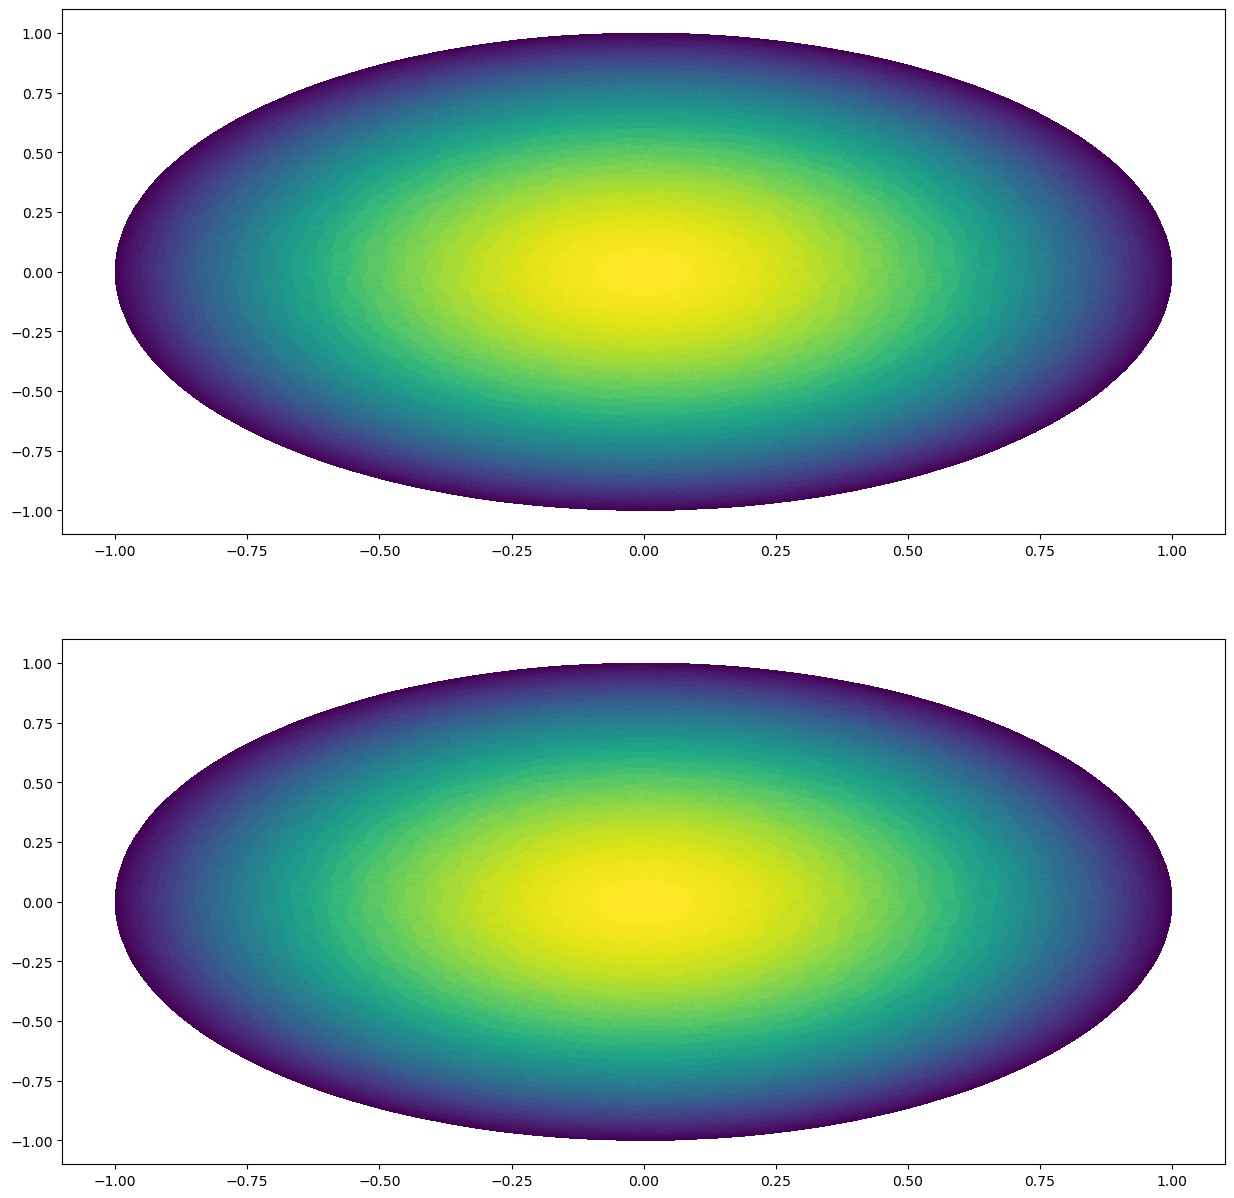

In [3]:
import matplotlib.tri as tri 

#triang = tri.Triangulation(x_down_chunk_cropped, y_down_chunk_cropped)

#triang = tri.Triangulation(theta_grid.ravel(), phi_grid.ravel())

triang_chunk = tri.Triangulation(x_down, y_down)

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(2,1, figsize=(15,15)) 

im = axes[0].tripcolor(triang_chunk, temperature_down, cmap='viridis')
im = axes[1].tripcolor(triang_chunk, temp_down, cmap='viridis')

In [4]:
print(f"temperature_down = {temperature_down[100:110]}")
print(f"temp_down = {temp_down[100:110]}")

print((temperature_down == temp_down).all())


differences = set(temperature_down).symmetric_difference(set(temp_down))
print(temperature_down.shape)
print(len(differences))

temperature_down = [-2.00400601e-06 -6.22436759e-01 -9.40040549e-01 -1.62061661e-01
 -2.25464775e-01 -9.72391786e-01 -5.43189654e-01 -6.45997863e-03
 -6.98520274e-01 -8.96319901e-01]
temp_down = [-2.00400601e-06 -6.22436759e-01 -9.40040549e-01 -1.62061661e-01
 -2.25464775e-01 -9.72391786e-01 -5.43189654e-01 -6.45997863e-03
 -6.98520274e-01 -8.96319901e-01]
False
(10000,)
6398


In [5]:
diff = list(zip(np.setdiff1d(temp_down, temperature_down), np.setdiff1d(temperature_down, temp_down))) 
print(diff[10:20])
print(len(diff))

[(-0.9999654184448147, -0.9999654184448148), (-0.9999653860739032, -0.9999653860739031), (-0.9999653439541131, -0.9999653439541132), (-0.9999652893965113, -0.9999652893965112), (-0.9999652841058067, -0.9999652841058069), (-0.9999652652572901, -0.9999652652572903), (-0.9999650966400342, -0.9999650966400341), (-0.9999650786976826, -0.9999650786976825), (-0.9999650423735211, -0.9999650423735209), (-0.9999650091194902, -0.9999650091194903)]
3199
